In [1]:
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [15]:
## UTIL

import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [12]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

sam = sam_model_registry["vit_h"](checkpoint="./model/sam_vit_h_4b8939.pth")
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
img_url = "./data/training/0000/panos/floor_01_partial_room_01_pano_15.jpg"
raw_image = cv2.imread(img_url)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
height, width = raw_image.shape[:2]
new_size = (width // 5, height // 5)
scaled_image = cv2.resize(raw_image, new_size, interpolation=cv2.INTER_AREA)
print(new_size)
plt.imshow(scaled_image)

In [18]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

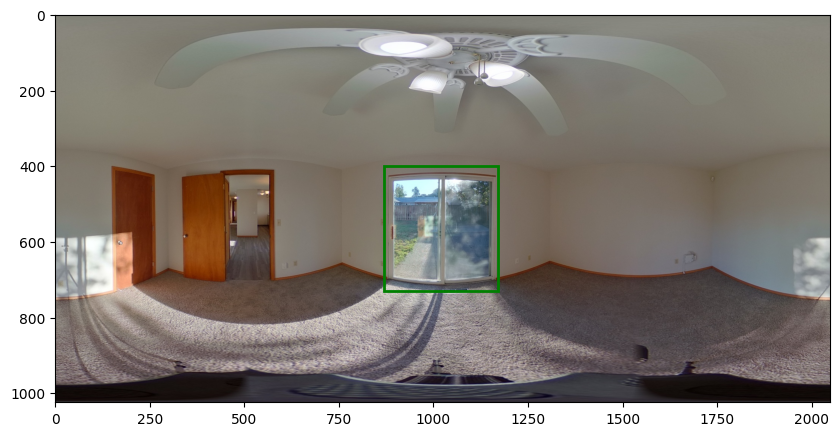

In [20]:
input_boxes = [[[870, 400, 1170, 730]]]
show_boxes_on_image(raw_image, input_boxes[0])

In [21]:
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
  outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

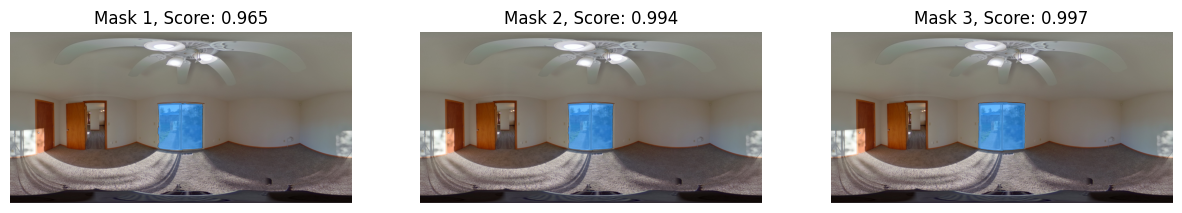

In [22]:
show_masks_on_image(raw_image, masks[0], scores)

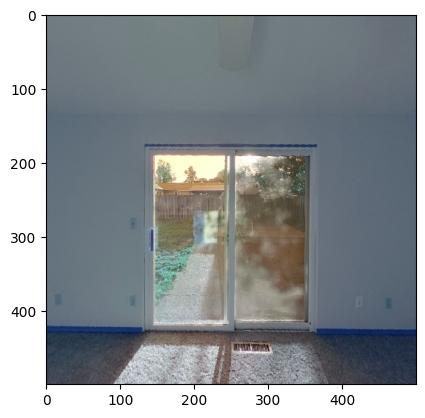

In [13]:
# Panorama to Perspective Projection

img_path = "./data/training/0000/panos/floor_01_partial_room_01_pano_15.jpg"

image = cv2.imread(img_path)
h, w = image.shape[:2]

# Define FOV
FOV = 90
theta = 0
phi = 0
output_size = (500,500)

output = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)

theta = np.radians(theta)
phi = np.radians(phi)
FOV = np.radians(FOV)

for y in range(output_size[1]):
  for x in range(output_size[0]):
    # Norm the coordinates
    nx = (2 * x / output_size[0] - 1) * np.tan(FOV / 2)
    ny = (2 * y / output_size[1] - 1) * np.tan(FOV / 2)
    
    r = np.sqrt(nx ** 2 + ny ** 2 + 1)
    phi_p = np.arcsin(ny / r)
    theta_p = np.arctan2(nx, 1)
    
    # Pixel coordinates in original image
    px = int((theta_p + np.pi) / (2 * np.pi) * w)
    py = int((phi_p + np.pi / 2) / np.pi * h)
    
    if 0 <= px < w and 0 <= py < h:
      output[y, x] = image[py, px]
      
plt.imshow(output)

In [23]:
# Loss Definition

import torch.nn.functional as F 

def compute_loss(pred_masks, true_masks, pred_scores, true_scores):

  mask_loss = F.binary_cross_entropy_with_logits(pred_masks, true_masks)
  score_loss = F.mse_loss(pred_scores, true_scores)
  
  return mask_loss + score_loss

In [24]:
# Add images and masks to array

import os

panos_dir = "./data/training/0000/panos"
masks_dir = "./data/training/0000/masks"

image_paths = []
mask_paths = []

for filename in os.listdir(panos_dir):
	if filename.endswith((".jpg", ".png")):
		image_path = os.path.join(panos_dir, filename)
		mask_name = f"mask_{os.path.splitext(filename)[0]}.png" 
		mask_path = os.path.join(masks_dir, mask_name)

		if os.path.exists(mask_path):
				image_paths.append(image_path)
				mask_paths.append(mask_path)
		else:
				print(f"No mask for {image_path} found")

print(f"Amount of images found: {len(image_paths)}")
print(f"Amount of masks found: {len(mask_paths)}")


Amount of images found: 32
Amount of masks found: 32


In [ ]:
# Transform image function
import os

def extract_views(img_path, output_size=(500, 500), fov=90):

	image = cv2.imread(img_path)
	h, w = image.shape[:2]

	angles = [0, 90, 180, 270]
	directions = ["front", "right", "back", "left"]

	fov = np.radians(fov)

	for angle, direction in zip(angles, directions):
		theta = np.radians(angle)

		output = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)
  
		for y in range(output_size[1]):
			for x in range(output_size[0]):
				# Norm the coordinates
				nx = (2 * x / output_size[0] - 1) * np.tan(fov / 2)
				ny = (2 * y / output_size[1] - 1) * np.tan(fov / 2)
				
				r = np.sqrt(nx ** 2 + ny ** 2 + 1)
				phi_p = np.arcsin(ny / r)
				theta_p = np.arctan2(nx, 1) + theta
    
				theta_p = (theta_p + np.pi) % (2 * np.pi) - np.pi
				
				# Pixel coordinates in original image
				px = int((theta_p + np.pi) / (2 * np.pi) * w) % w
				py = int((phi_p + np.pi / 2) / np.pi * h)
				
				if 0 <= px < w and 0 <= py < h:
					output[y, x] = image[py, px]
     
		dir_path = os.path.dirname(img_path)
		img_name = os.path.basename(img_path)

		output_path = f"{os.path.split(dir_path)[0]}/directions/{direction}_{img_name}" 
		cv2.imwrite(output_path, output)
		print(f"Saved: {output_path}")


In [ ]:
# Transform all images of one house 
panos_dir = "./data/training/0000/panos/"
for filename in os.listdir(panos_dir):
  extract_views(panos_dir + filename)

In [25]:
# Dataset definition

class WindowSegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.transform = transform
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    mask = Image.open(self.mask_paths[idx]).convert("L")
    
    if (self.transform):
      image = self.transform(image)
      mask = self.transform(mask)
      
    return image, mask

transform = transforms.Compose([
	transforms.Resize((409, 204)),
 	transforms.ToTensor(),
])

dataset = WindowSegmentationDataset(image_paths, mask_paths, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [26]:
scores = outputs.iou_scores.squeeze().tolist()
max_index = scores.index(max(scores))
print(scores)
max_index

[0.9651146531105042, 0.9944816827774048, 0.9968433380126953]


2

In [ ]:
# Training

model.train()

optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(10): 
	for images, masks in data_loader:
		images, masks = images.to(device), masks.to(device)

		inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
		image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
		outputs = model(**inputs)

		pred_masks = outputs.pred_masks

		# Choose best mask 
		scores = outputs.iou_scores.squeeze().tolist()
		max_index = scores.index(max(scores))
	
		best_mask = pred_masks[:, :, max_index]
		print(f"Mask scores: {scores}")
		print(f"Best mask: {max_index}")
		print(f"Selected Predicted Masks Size: {best_mask.size()}")
		print(f"Original Ground-Truth Masks Size: {masks.size()}") 

		# Scale ground truth masks
		true_masks_resized = F.interpolate(masks, size=(256, 256), mode="bilinear", align_corners=False)

		# Convert to binary
		true_masks_resized = (true_masks_resized > 0.5).float()

		print(f"Resized Ground-Truth Masks Size: {true_masks_resized.size()}")

		# Loss
		mask_loss = F.binary_cross_entropy_with_logits(best_mask, true_masks_resized)

		# Backpropagation
		optimizer.zero_grad()
		mask_loss.backward()
		optimizer.step()

		print(f"Epoch {epoch}, Loss: {mask_loss.item()}")

